# Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from datetime import datetime, time

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print ("Início Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Início Execução : 
2021-07-23 16:53:40


# Funções Auxiliares

In [4]:
def get_dados(path, df):
    X = []
    Y = []
    print(f"Serão carregadas {df.shape[0]} imagens")
    for idx, image, label in zip(df.index, df.image, df.label):
        if (idx % 100 == 0):
            print(idx, end=' : ')
        arquivo = f"{path}/{image}"
        img_xray = img_to_array(load_img(arquivo, color_mode='grayscale', target_size=(64, 64)))
        X.append(img_xray)
        if (label == 'Normal'):
            Y.append(0)
        else:
            Y.append(1)
            
    return (X, Y)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, f1, 'k', label='Training F1 Score')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.plot(x, val_f1, 'g', label='Validation F1 Score')
    plt.title('Acurácia e F1 Score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Perda')
    plt.legend()
    
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
        
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val    

# Carregando os dados 

In [5]:
path_treino = './data/Xray/train' 
path_teste = './data/Xray/test'

In [6]:
df = pd.read_csv("./data/Xray/Chest_xray_Corona_Metadata.csv", usecols=[1,2,3], header=0, names=['image', 'label', 'dataset'])

In [7]:
df.head()

,image,label,dataset
0,IM-0128-0001.jpeg,Normal,TRAIN
1,IM-0127-0001.jpeg,Normal,TRAIN
2,IM-0125-0001.jpeg,Normal,TRAIN
3,IM-0122-0001.jpeg,Normal,TRAIN
4,IM-0119-0001.jpeg,Normal,TRAIN


In [8]:
df_train = df[df.dataset == 'TRAIN']
df_test = df[df.dataset == 'TEST']

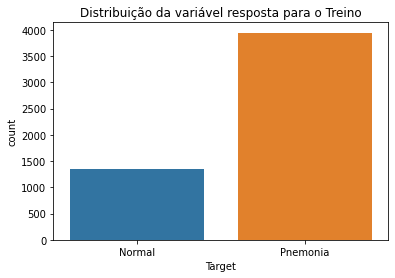

In [9]:
sns.countplot(x =df_train.label)
plt.title('Distribuição da variável resposta para o Treino')
plt.xlabel('Target')
plt.xticks()
plt.show()

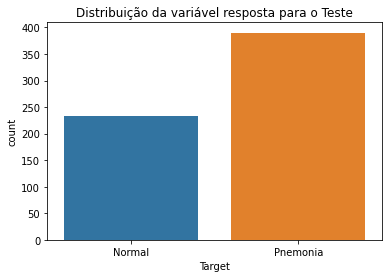

In [10]:
sns.countplot(x =df_test.label)
plt.title('Distribuição da variável resposta para o Teste')
plt.xlabel('Target')
plt.xticks()
plt.show()

In [11]:
# carregando as imagens com tamanho 64x64 (para a LENET5) e os labels em memória
X_xray, y_xray = get_dados(path_treino, df_train)

Serão carregadas 5286 imagens
0 : 100 : 200 : 300 : 400 : 500 : 600 : 700 : 800 : 900 : 1000 : 1100 : 1200 : 1300 : 1400 : 1500 : 1600 : 1700 : 1800 : 1900 : 2000 : 2100 : 2200 : 2300 : 2400 : 2500 : 2600 : 2700 : 2800 : 2900 : 3000 : 3100 : 3200 : 3300 : 3400 : 3500 : 3600 : 3700 : 3800 : 3900 : 4000 : 4100 : 4200 : 4300 : 4400 : 4500 : 4600 : 4700 : 4800 : 4900 : 5000 : 5100 : 5200 : 

In [12]:
X_xray[0].shape

(64, 64, 1)

person1669_bacteria_4422.jpeg


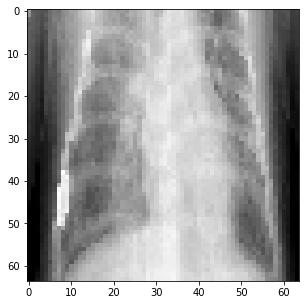

In [13]:
plt.figure(figsize=(5,5))
idx = 2765
plt.imshow(array_to_img(X_xray[idx]), cmap="gray")
print(df.image[idx])

In [14]:
y_xray[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
len(X_xray)

5286

In [16]:
len(y_xray)

5286

In [17]:
X_xray[0]

array([[[ 0.],
        [ 8.],
        [30.],
        ...,
        [27.],
        [18.],
        [ 6.]],

       [[ 0.],
        [ 1.],
        [20.],
        ...,
        [25.],
        [17.],
        [ 3.]],

       [[ 0.],
        [ 0.],
        [16.],
        ...,
        [15.],
        [ 6.],
        [ 1.]],

       ...,

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]]], dtype=float32)

In [18]:
X = np.asarray(X_xray).astype(np.float32)
Y = np.asarray(y_xray)

## Padronizando os dados, que estão entre 0 e 255, dividindo por 255.
### Dados padronizados entre 0 e 1.

In [19]:
X = X/255
X.shape

(5286, 64, 64, 1)

In [20]:
Y.shape

(5286,)

## Dividindo a Base de Dados de treino entre treino e validação, com 20% para a validação.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Modelo de MLP

## Criando o modelo Lenet5 padrão com a função de ativação "relu"

In [34]:
# Cria o modelo
model = Sequential()
model.add(Conv2D(12, (5, 5), input_shape=(64, 64, 1), activation='relu'))   
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (5, 5), activation='relu'))  
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 12)        312       
_________________________________________________________________
average_pooling2d_2 (Average (None, 30, 30, 12)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9632      
_________________________________________________________________
average_pooling2d_3 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)             

In [21]:
#plot_model(model, show_shapes=True, show_layer_names=True)

## Compilando e treinando o modelo. 
### Vamos utilizar a função de Callback ModelCheckPointer para salvar o modelo com a melhor accuracia na base de validação.

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

checkpointer = ModelCheckpoint_tweaked(filepath='./modelo_mlp_ex8_3.hdf5', verbose=1,  mode='max', save_best_only=True, monitor='val_get_f1')
#checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex8_3.hdf5', verbose=1,  save_best_only=True, monitor='val_accuracy')

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=40, batch_size=16, verbose=1, callbacks=[checkpointer])

Epoch 1/30
265/265 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8609 - get_f1: 0.9107
Epoch 00001: val_get_f1 improved from -inf to 0.93674, saving model to .\modelo_mlp_ex8_3.hdf5
265/265 [==============================] - 2s 8ms/step - loss: 0.3284 - accuracy: 0.8609 - get_f1: 0.9107 - val_loss: 0.2469 - val_accuracy: 0.9036 - val_get_f1: 0.9367
Epoch 2/30
261/265 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9358 - get_f1: 0.9551
Epoch 00002: val_get_f1 improved from 0.93674 to 0.95814, saving model to .\modelo_mlp_ex8_3.hdf5
265/265 [==============================] - 2s 6ms/step - loss: 0.1684 - accuracy: 0.9350 - get_f1: 0.9546 - val_loss: 0.1399 - val_accuracy: 0.9395 - val_get_f1: 0.9581
Epoch 3/30
265/265 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9489 - get_f1: 0.9650
Epoch 00003: val_get_f1 improved from 0.95814 to 0.96918, saving model to .\modelo_mlp_ex8_3.hdf5
265/265 [=======================

## Gráfico comparativo da Acurácia e Perda no treinamento

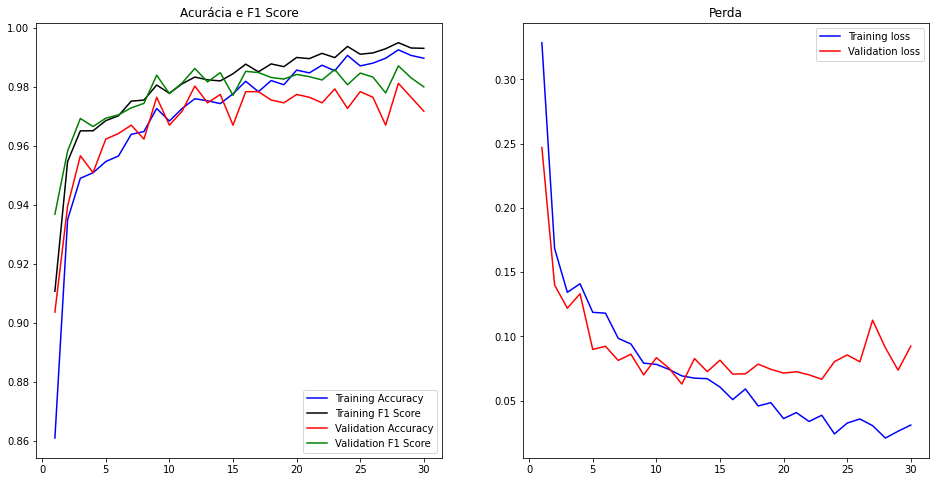

In [24]:
plot_history(history)

## Apresentando a Acurácia final do Treino, carregando o melhor modelo salvo e apresentando a Acurácia da Validação

In [25]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acurácia do Treino: {round(scores[1]*100,2)}%")
print(f"F1 Score do Treino: {round(scores[2]*100,2)}%")

133/133 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.9981 - get_f1: 0.9988

Acurácia do Treino: 99.81%
F1 Score do Treino: 99.88%


In [26]:
model = load_model("./modelo_mlp_ex8_3.hdf5", custom_objects={'get_f1': get_f1})

In [27]:
scores = model.evaluate(X_val, y_val)
print()
print(f"Acurácia da Validação: {round(scores[1]*100,2)}%")
print(f"F1 Score da Validação: {round(scores[2]*100,2)}%")

34/34 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9811 - get_f1: 0.9868

Acurácia da Validação: 98.11%
F1 Score da Validação: 98.68%


## Carregando os dados para o Teste e aplicando os mesmos pré processamentos

In [28]:
X_xray, y_xray = get_dados(path_teste, df_test)

Serão carregadas 624 imagens
5300 : 5400 : 5500 : 5600 : 5700 : 5800 : 5900 : 

In [30]:
X_test = np.asarray(X_xray).astype(np.float32)
y_test = np.asarray(y_xray)

In [31]:
X_test = X_test/255
X_test.shape

(624, 64, 64, 1)

In [32]:
y_test.shape

(624,)

In [33]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acurácia do Teste: {round(scores[1]*100,2)}%")
print(f"F1 Score do Teste: {round(scores[2]*100,2)}%")

20/20 [==============================] - 0s 3ms/step - loss: 2.1809 - accuracy: 0.7724 - get_f1: 0.6442

Acurácia do Teste: 77.24%
F1 Score do Teste: 64.42%


In [33]:
print ("Fim Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Fim Execução : 
2021-07-19 18:29:09
